In [184]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from iexfinance.stocks import get_historical_intraday
from scipy.stats.mstats import gmean
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
plt.rcParams['figure.figsize'] = [10.0, 6.0]

In [185]:
#import sys
#!{sys.executable} -m pip install seaborn-qqplot

# Initial params

In [235]:
rollingWindow = 20
ticker = 'AAPL'
start = datetime(2020, 1, 1)
end = datetime.now()

# Loading intraday data

In [186]:
path = f'{ticker}_intraday.pkl'
if os.path.exists(path):
    print(f"Loaded intraday data from {path}")
    intraday = pd.read_pickle(path)
else:
    os.environ['IEX_TOKEN'] = '<put key here>' # insert your API key
    dfs = []
    for dt in pd.date_range(start, end, freq='B'):
        print(f"Loading intraday data for {dt}")
        df = get_historical_intraday(ticker, dt, output_format='pandas')
        if len(df)>0:
            df = df.loc[:,['date','marketOpen','marketClose','marketVolume']]
            df.rename(columns={'marketOpen':'open', 'marketClose':'close', 'marketVolume':'volume'}, inplace=True)
            dfs.append(df)
    
    intraday = pd.concat(dfs)
    intraday.index = pd.to_datetime(intraday.index)
    intraday.date = pd.to_datetime(intraday.date)
    print(f"Saved intraday data to {path}")
    intraday.to_pickle(path)

intraday.head()

Loaded intraday data from AAPL_intraday.pkl


,date,open,close,volume,vc
2020-01-02 09:30:00,2020-01-02,296.24,295.755,785402.0,0.030043
2020-01-02 09:31:00,2020-01-02,295.70,295.530,201047.0,0.007690
2020-01-02 09:32:00,2020-01-02,295.49,295.705,172261.0,0.006589
2020-01-02 09:33:00,2020-01-02,295.71,296.550,295317.0,0.011296
2020-01-02 09:34:00,2020-01-02,296.53,296.870,195182.0,0.007466


Prepare daily aggregate and geometric moving average

In [187]:
daily = intraday.groupby('date').agg({'open': 'first', 'close': 'last', 'volume': 'sum'})
daily.index = pd.to_datetime(daily.index)
daily['gmav'] = daily.volume.rolling(rollingWindow).agg(gmean).transform(np.ceil)
daily.tail()

,open,close,volume,gmav
date,,,,
2020-05-04,289.18,293.170,25662700.0,27712585.0
2020-05-05,295.06,297.780,28752517.0,27432351.0
2020-05-06,300.46,300.500,27768774.0,26971235.0
2020-05-07,303.22,303.750,21814655.0,26575761.0
2020-05-08,305.64,310.149,25083078.0,26310883.0


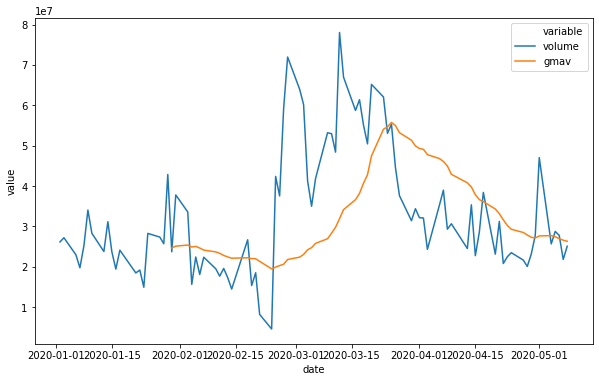

In [188]:
sns.lineplot(x='date', y='value', hue='variable', data=daily.loc[:,['volume','gmav']].reset_index().melt(id_vars=['date']))
plt.show()

# Fit lognorm dist
For some reason scipy fails to accurately fit lognorm to volume, so fitting norm to log volume

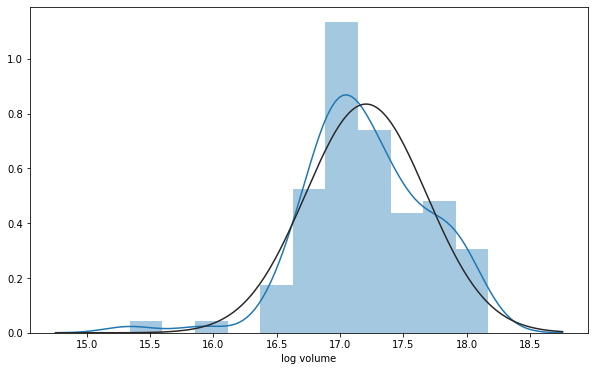

In [189]:
sns.distplot(np.log(daily.volume), fit=stats.norm, axlabel='log volume')
plt.show()

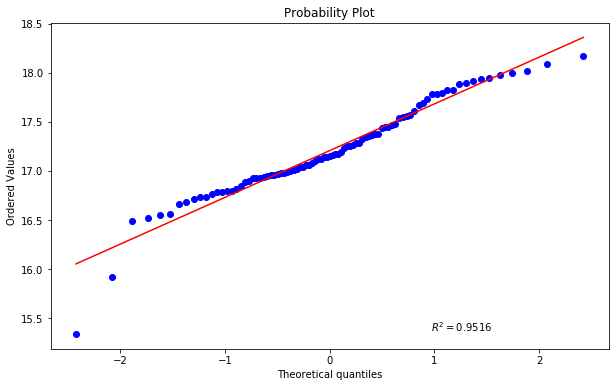

In [190]:
_ = stats.probplot(np.log(daily.volume), dist=stats.norm,  plot=plt, rvalue=True)

# Fitting invgamma

/Users/Andrey/anaconda3/envs/FinEng/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


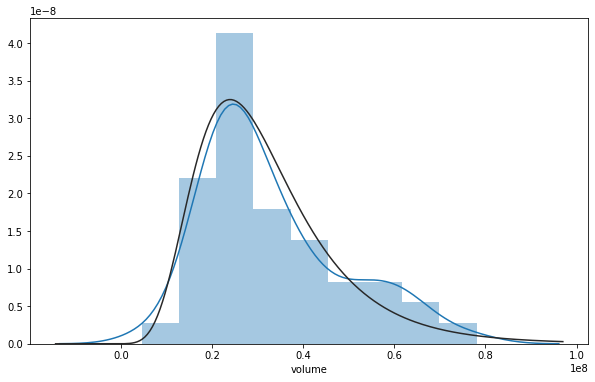

In [191]:
sns.distplot(daily.volume, fit=stats.invgamma)
plt.show()

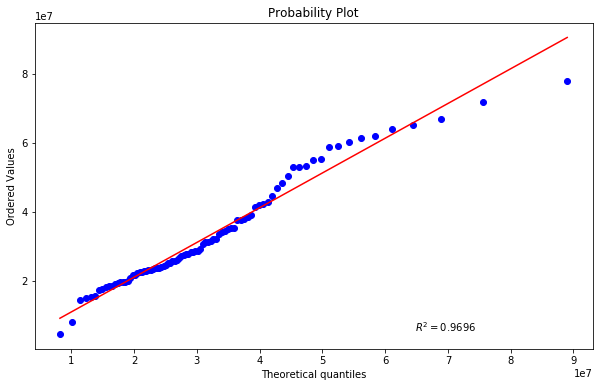

In [192]:
_ = stats.probplot(daily.volume, dist=stats.invgamma, sparams=stats.invgamma.fit(daily.volume), plot=plt, rvalue=True)

# Fitting gamma

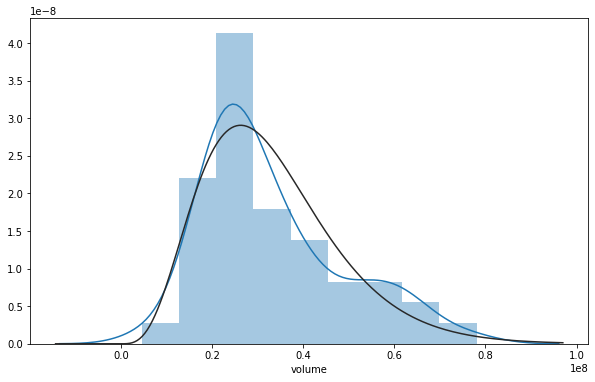

In [193]:
sns.distplot(daily.volume, fit=stats.gamma)
plt.show()

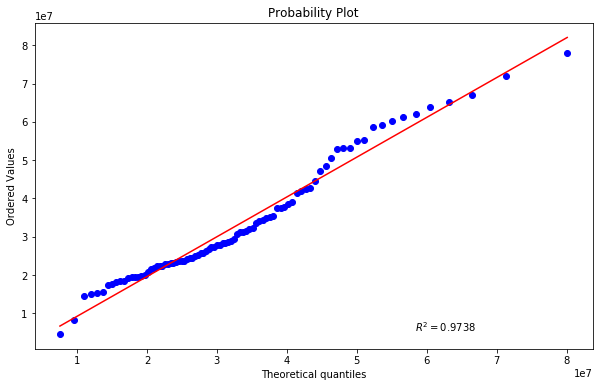

In [194]:
_ = stats.probplot(daily.volume, dist=stats.gamma, sparams=stats.gamma.fit(daily.volume), plot=plt, rvalue=True)

# ARMA for initial daily volume prediction

In [195]:
daily["lv"] = np.log(daily.volume)
daily["mulv"] = daily.lv.rolling(rollingWindow).mean()
daily["slv"] = daily.lv - daily.mulv
daily.tail()

,open,close,volume,gmav,lv,mulv,slv
date,,,,,,,
2020-05-04,289.18,293.170,25662700.0,27712585.0,17.060549,17.137397,-0.076848
2020-05-05,295.06,297.780,28752517.0,27432351.0,17.174236,17.127234,0.047002
2020-05-06,300.46,300.500,27768774.0,26971235.0,17.139423,17.110281,0.029141
2020-05-07,303.22,303.750,21814655.0,26575761.0,16.898093,17.095510,-0.197418
2020-05-08,305.64,310.149,25083078.0,26310883.0,17.037704,17.085493,-0.047789


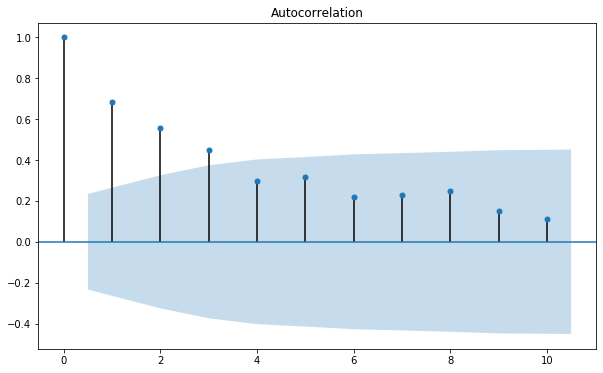

In [196]:
plot_acf(daily.slv.dropna(), lags=10)
plt.show()

In [204]:
model = ARIMA(daily.slv.dropna(), order=(3,0,1))
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    slv   No. Observations:                   70
Model:                     ARMA(3, 1)   Log Likelihood                 -23.924
Method:                       css-mle   S.D. of innovations              0.333
Date:                Tue, 12 May 2020   AIC                             57.847
Time:                        23:29:58   BIC                             69.090
Sample:                             0   HQIC                            62.313
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.slv     -0.3600      0.114     -3.155      0.002      -0.584      -0.136
ar.L2.slv      0.6152      0.097      6.351      0.000       0.425       0.805
ar.L3.slv      0.2515      0.117      2.154      0.0

/Users/Andrey/anaconda3/envs/FinEng/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


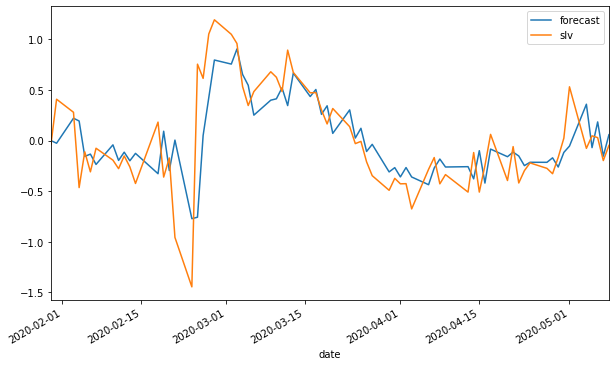

In [65]:
model_fit.plot_predict()
plt.show()

# Intraday volume curve

In [220]:
intraday['vc'] = intraday.loc[:,['date','volume']].groupby('date').apply(lambda x: x / float(x.sum()))
intraday['time'] = intraday.index.time
intraday.tail()

,date,open,close,volume,vc,time
2020-05-08 15:55:00,2020-05-08,310.22,310.185,143280.0,0.005712,15:55:00
2020-05-08 15:56:00,2020-05-08,310.18,310.080,118690.0,0.004732,15:56:00
2020-05-08 15:57:00,2020-05-08,310.08,309.980,135596.0,0.005406,15:57:00
2020-05-08 15:58:00,2020-05-08,309.99,309.980,188162.0,0.007502,15:58:00
2020-05-08 15:59:00,2020-05-08,309.97,310.149,403775.0,0.016098,15:59:00


In [221]:
VC = intraday.loc[:,['time','vc']].groupby('time').mean() # average over many days
VC.vc = VC.vc/VC.vc.sum() # normalize to 1
VC['cumVC'] = VC.vc.cumsum()
VC

,vc,cumVC
time,,
09:30:00,0.031244,0.031244
09:31:00,0.008540,0.039784
09:32:00,0.007472,0.047256
09:33:00,0.007037,0.054293
09:34:00,0.006554,0.060847
...,...,...
15:55:00,0.006190,0.965665
15:56:00,0.005452,0.971118
15:57:00,0.006150,0.977268


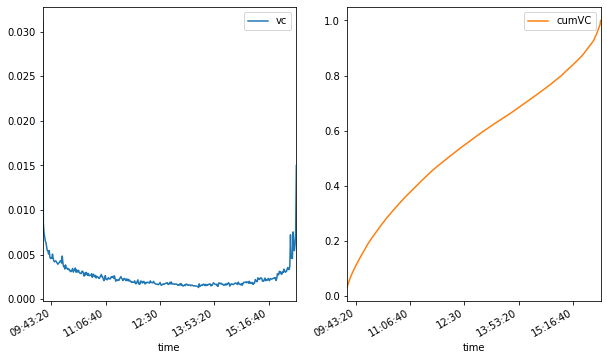

In [230]:
VC.plot(subplots=True, layout=(1,2))
plt.show()

In [234]:
realized = intraday.where(intraday.date==intraday.date.max()).dropna().reset_index().loc[:,['time','volume']].set_index('time')
realized["cumVolume"] = realized.volume.cumsum()
realized

,volume,cumVolume
time,,
09:30:00,593766.0,593766.0
09:31:00,155862.0,749628.0
09:32:00,159134.0,908762.0
09:33:00,130586.0,1039348.0
09:34:00,142278.0,1181626.0
...,...,...
15:55:00,143280.0,24236855.0
15:56:00,118690.0,24355545.0
15:57:00,135596.0,24491141.0


In [253]:
predictedLogExcess = model_fit.predict().array[-1]
predictedDailyLV = daily.mulv.array[-2] + predictedLogExcess # previous day rolling mean + excess
predictedDailyLV

17.153694836056076

In [237]:
k0 = 0.8 * rollingWindow

In [264]:
prediction = realized.join(VC)
prediction['x'] = np.log(prediction.volume/prediction.vc)
prediction['n'] = np.arange(1,len(prediction)+1)
prediction['xbar'] = prediction.x.expanding().mean()
prediction['mu'] = (predictedDailyLV*k0+prediction.n*prediction.xbar)/(k0+prediction.n)
prediction['predictedVolume'] = np.ceil(np.exp(prediction.mu))
prediction

,volume,cumVolume,vc,cumVC,x,n,xbar,mu,predictedVolume
time,,,,,,,,,
09:30:00,593766.0,593766.0,0.031244,0.031244,16.760172,1,16.760172,17.130546,27523382.0
09:31:00,155862.0,749628.0,0.008540,0.039784,16.719755,2,16.739963,17.107725,26902363.0
09:32:00,159134.0,908762.0,0.007472,0.047256,16.874040,3,16.784656,17.095425,26573513.0
09:33:00,130586.0,1039348.0,0.007037,0.054293,16.736387,4,16.772588,17.077474,26100723.0
09:34:00,142278.0,1181626.0,0.006554,0.060847,16.893264,5,16.796724,17.068702,25872772.0
...,...,...,...,...,...,...,...,...,...
15:55:00,143280.0,24236855.0,0.006190,0.965665,16.957312,386,16.882002,16.892816,21699844.0
15:56:00,118690.0,24355545.0,0.005452,0.971118,16.895988,387,16.882038,16.892823,21700015.0
15:57:00,135596.0,24491141.0,0.006150,0.977268,16.908732,388,16.882107,16.892863,21700869.0
